In [28]:
import re
import nltk
import pandas as pd
import matplotlib.pyplot as plt

from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
from wordcloud import WordCloud

In [29]:
# -------------------------------------------------------------------
# Load Data
# -------------------------------------------------------------------
data = pd.read_csv('Data/twits.csv')
final_results = pd.DataFrame({'tweet_id': data['tweet_id']})

In [30]:
# -------------------------------------------------------------------
# Helper Functions
# -------------------------------------------------------------------

def get_wordnet_pos(treebank_tag):
    """
    Convert NLTK POS tags (e.g., 'NN', 'VB') to WordNet POS tags.
    """
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    return wordnet.NOUN

In [31]:
# -------------------------------------------------------------------
# Text Preprocessing Class
# -------------------------------------------------------------------

class TextPreprocessor:
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.stemmer = PorterStemmer()
        self.lemmatizer = WordNetLemmatizer()

    def clean_text(self, text):
        """
        Full preprocessing: lowercase, remove URLs, remove @numeric IDs,
        remove digits if URL existed, remove punctuation and special chars.
        """
        if pd.isna(text):
            return ""

        text = str(text).lower()

        # Identify and remove URLs
        url_pattern = r'https?://\S+|www\.\S+'
        url_found = bool(re.search(url_pattern, text))
        text = re.sub(url_pattern, ' ', text)

        # Remove digits only if URL was present
        if url_found:
            text = re.sub(r'\d+', ' ', text)

        # Remove numeric Twitter IDs
        text = re.sub(r'@\d+', ' ', text)

        # Remove punctuation, emojis, and special characters
        text = re.sub(r'[^a-z\s]', ' ', text)

        # Remove extra spaces
        return re.sub(r'\s+', ' ', text).strip()

    def tokenize(self, text):
        """Tokenize text into a list of words."""
        return word_tokenize(text)

    def remove_stopwords(self, tokens):
        """Remove English stopwords."""
        return [word for word in tokens if word not in self.stop_words]

    def pos_tag(self, tokens):
        """POS-tag a list of tokens."""
        return nltk.pos_tag(tokens)

    def stem(self, tokens):
        """Apply Porter stemming."""
        return [self.stemmer.stem(word) for word in tokens]

    def lemmatize(self, tokens):
        """Lemmatize tokens using POS tagging for accuracy."""
        pos_tags = nltk.pos_tag(tokens)
        return [self.lemmatizer.lemmatize(word, get_wordnet_pos(tag)) 
                for word, tag in pos_tags]


In [32]:

# -------------------------------------------------------------------
# Apply the Pipeline
# -------------------------------------------------------------------

processor = TextPreprocessor()

data['preprocessed_text'] = data['text'].apply(processor.clean_text)
data['tokens'] = data['preprocessed_text'].apply(processor.tokenize)
data['filtered_tokens'] = data['tokens'].apply(processor.remove_stopwords)
data['pos_tags'] = data['filtered_tokens'].apply(processor.pos_tag)
data['stemmed_tokens'] = data['filtered_tokens'].apply(processor.stem)
data['lemmatized_tokens'] = data['filtered_tokens'].apply(processor.lemmatize)

# Save readable outputs
final_results['preprocessed_text'] = data['preprocessed_text']
final_results['tokens'] = data['tokens'].apply(lambda x: ' '.join(x))
final_results['filtered_tokens'] = data['filtered_tokens'].apply(lambda x: ' '.join(x))
final_results['pos_tags'] = data['pos_tags'].apply(lambda x: ' '.join([f"{w}/{t}" for w, t in x]))
final_results['stemmed_tokens'] = data['stemmed_tokens'].apply(lambda x: ' '.join(x))
final_results['lemmatized_tokens'] = data['lemmatized_tokens'].apply(lambda x: ' '.join(x))


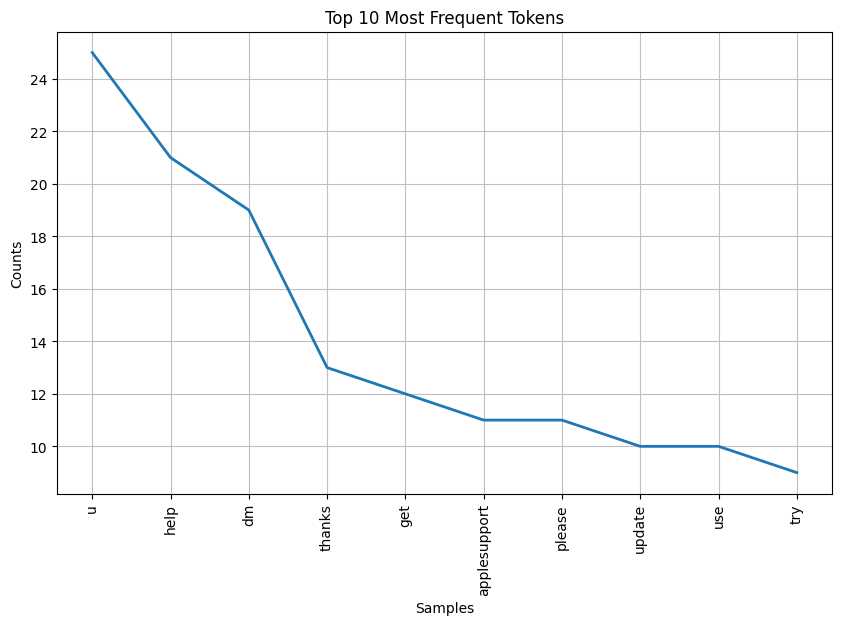

In [40]:
# -------------------------------------------------------------------
# Visualization: Frequency Distribution
# -------------------------------------------------------------------

all_text = " ".join(final_results['lemmatized_tokens'].tolist())
tokens = word_tokenize(all_text)

freq_dist = nltk.FreqDist(tokens)

plt.figure(figsize=(10, 6))
freq_dist.plot(10, cumulative=False)
plt.title("Top 10 Most Frequent Tokens")
plt.show()

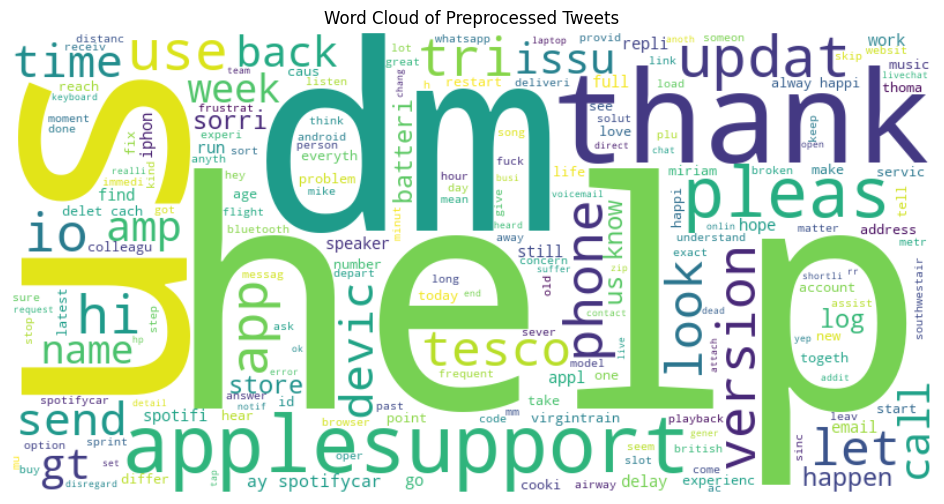

In [ ]:
# -------------------------------------------------------------------
# Visualization: Word Cloud
# -------------------------------------------------------------------

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of stemmed Tweets")
plt.show()